## Artificial vortex array flow test

## Averaged flows


In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
import pickle 
import os
import sys
import pandas as pd

sys.path.append('../vasco_scripts')  # add the relative path to the folder
from defects import *  # import the module from the folder

def analyze_defects(img, sigma=15):
    # Calculate mgrid
    yy, xx = np.mgrid[0:img.shape[0], 0:img.shape[1]]
    
    # Calculate orientation analysis
    ori, coh, E = orientation_analysis(img, sigma)
    
    # Compute topological charges
    k = compute_topological_charges(-ori, int_area='cell', origin='lower')
    
    # Localize defects
    defects = localize_defects(k, x_grid=xx, y_grid=yy)
    
    # Compute defect orientation
    compute_defect_orientations(-ori, defects, method='interpolation', x_grid=xx[0,:], y_grid=yy[:,0], interpolation_radius=5, min_sep=1)
    
    # Filter defects by charge
    plushalf = defects[defects['charge']==.5]
    minushalf = defects[defects['charge']==-.5]
    
    return ori, plushalf, minushalf

%matplotlib qt

import sys,time,random
def progressBar(count_value, total, suffix=''):
    bar_length = 100
    filled_up_Length = int(round(bar_length* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    sys.stdout.write('[%s] %s%s ...%s\r' %(bar, percentage, '%', suffix))
    sys.stdout.flush()


image_list = glob.glob(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\*.tif")
image_list = natsorted(image_list, key=lambda y: y.lower())

### Test flow parameters
`flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)`

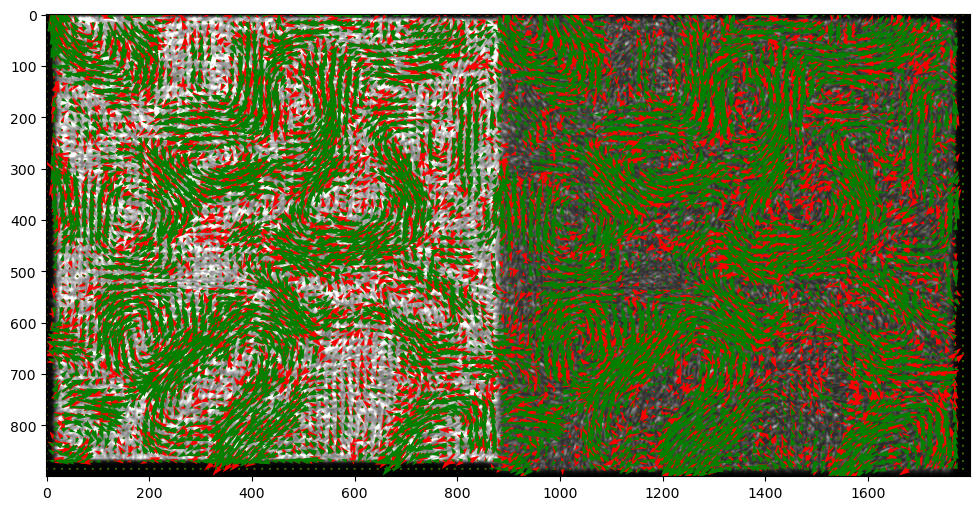

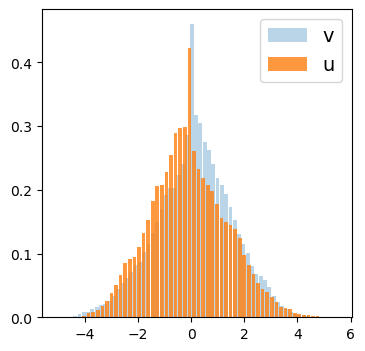

In [2]:
%matplotlib inline
skip = 1
n = 10 * skip

u = np.zeros_like(cv2.imread(image_list[0])[:,:,0], dtype=np.float32)
v = np.zeros_like(u)

for (i,im1), im2 in zip(enumerate(image_list[:n:skip]), image_list[1:n+1:skip]):

    img1 = cv2.imread(im1)[:,:,0]
    img2 = cv2.imread(im2)[:,:,0]
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) 
    u += flow[..., 0]
    v += flow[..., 1]

step = 15
fig, ax1 = plt.subplots(1,1,  figsize=(12,6))
ax1.imshow(img1, cmap="gray")

x = np.arange(0, flow.shape[1], step, dtype=np.int16)
y = np.arange(0, flow.shape[0], step, dtype=np.int16)
ax1.quiver(x,y, 
        flow[::step, ::step, 0], -flow[::step, ::step, 1], 
        color="red", scale=150)
ax1.quiver(x,y, 
        u[::step, ::step]/(i+1), -v[::step, ::step]/(i+1), 
        color="green", scale=150)

fig, ax2 = plt.subplots(1,1,  figsize=(4,4))
ax2.hist(np.concatenate(v)/(i+1), 60, alpha=.3, rwidth=.9, density=True, label="v")
ax2.hist(np.concatenate(u)/(i+1),60, alpha=.8, rwidth=.8, density=True, label="u")
plt.legend(loc='upper right', fontsize=14)

In [ ]:
%matplotlib inline
SAVE = True
PLOT = False
CHECK  = False

for (i,im1), im2 in zip(enumerate(image_list[:-1]), image_list[1:]):
    #right image [:,900:,0] / left image [:,:900,0]
    img1 = cv2.imread(im1)[:,900:,0]
    img2 = cv2.imread(im2)[:,900:,0]
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    
    save_path = os.path.join(
        os.path.dirname(image_list[i]), 
        'OptFlow', 
        os.path.splitext(os.path.basename(image_list[i]))[0] + '_u_v.pkl'
        )
    step = 15   

    if PLOT:
        fig = plt.figure(figsize=(10,10))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img1)
        plt.imshow(255-img_clahe, cmap="gray")

        x = np.arange(0, flow.shape[1], step, dtype=np.int16)
        y = np.arange(0, flow.shape[0], step, dtype=np.int16)
        plt.quiver(x,y, 
                flow[::step, ::step, 0], -flow[::step, ::step, 1], 
                color="red", scale=150, label="flow")
    
    if SAVE:  
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        scale = 3
        with open(save_path, 'wb') as f:
                pickle.dump(dict(u=flow[::scale,::scale,0], v=flow[::scale,::scale,1], scale=scale), f)
    
    if CHECK:
        with open(save_path, 'rb') as f:
            loaded_dict = pickle.load(f)  

        sstep = step//loaded_dict["scale"]
        plt.quiver(x, y,
                loaded_dict["u"][::sstep, ::sstep], -loaded_dict["v"][::sstep, ::sstep], 
                color="green", scale=200, label="dict")
    
    # break

    
    progressBar(i, len(image_list))
plt.legend(loc='upper right', fontsize=14)

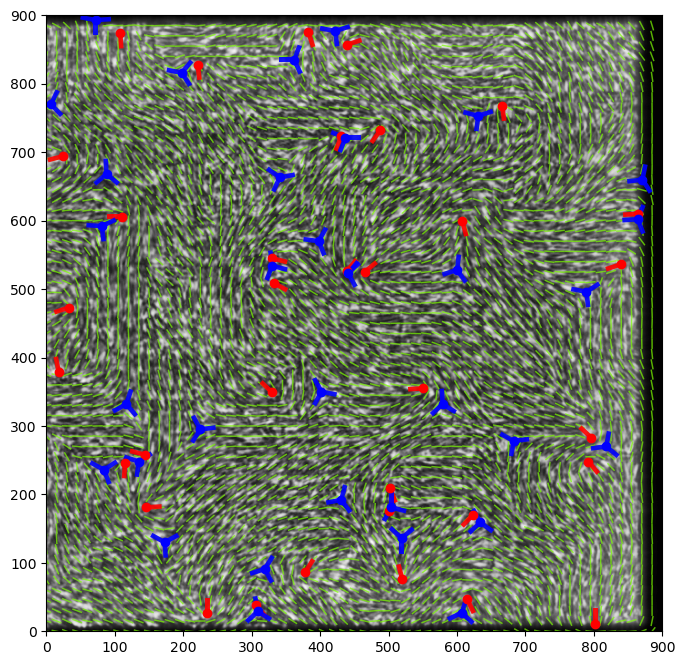

In [3]:
%matplotlib inline
PLOT = True
SAVE = True
minushalf_df = pd.DataFrame([])
plushalf_df = pd.DataFrame([])
if PLOT:
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())


for i,im1 in enumerate(image_list[:]):
    img1 = cv2.imread(im1)[:,900:,0]
    ori, plushalf, minushalf = analyze_defects(img1, sigma=11)
    frame_num = int(os.path.splitext(os.path.basename(im1))[0].split("_X")[-1])
    minushalf['frame'] = frame_num
    plushalf['frame'] = frame_num
    minushalf_df = pd.concat([minushalf_df, minushalf], ignore_index=True)
    plushalf_df = pd.concat([plushalf_df, plushalf], ignore_index=True)

    if PLOT:
        ax.clear() 
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img1)
        ax.imshow(img_clahe, cmap="gray")

        s = 15
        x = np.arange(0, img1.shape[1], s)
        y = np.arange(0, img1.shape[0], s)

        ax.quiver(x,y, #xx[::s,::s], yy[::s,::s],
            np.cos(ori)[::s,::s], -np.sin(ori)[::s,::s], 
            headaxislength=0, headwidth=0, headlength=0, 
            color='lawngreen', scale=60, pivot='mid', alpha=.7)

        alpha_half, scale_half = .9, 40    
        ax.plot(plushalf['x'], plushalf['y'],'ro',markersize=6, alpha=1)
        ax.quiver(plushalf['x'], plushalf['y'], 
            np.cos(plushalf['ang1']), np.sin(plushalf['ang1']), 
            headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

        ax.plot(minushalf['x'], minushalf['y'],'bo',markersize=6, alpha=1)
        for j in range(3):
            ax.quiver(minushalf['x'], minushalf['y'], 
                np.cos(minushalf['ang'+str(j+1)]), np.sin(minushalf['ang'+str(j+1)]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)
        
        # ----- Save Images with overlay of defects and director field  -----
        if SAVE and PLOT:
            save_path = os.path.join(
                r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects",
                'Nematic1',
                'frame_' + str(i) + ".png"
                )
            # break
            ax.set_xlim([0, 900])
            ax.set_ylim([0, 900])
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))

        # break
    # ---------------- Save CSV ----------------
    # if not i %50:  
    #     save_path = os.path.join(os.path.dirname(im1), 'Defects', 'MinusHalf1.csv')
    #     os.makedirs(os.path.dirname(save_path), exist_ok=True)
    #     minushalf_df.to_csv(save_path)
    #     save_path = os.path.join(os.path.dirname(im1), 'Defects', 'PlusHalf1.csv')
    #     plushalf_df.to_csv(save_path)

    # save_path = os.path.join(
    #         os.path.dirname(im1), 
    #         'Nematic', 
    #         os.path.splitext(os.path.basename(im1))[0]
    #         )
    # os.makedirs(os.path.dirname(save_path), exist_ok=True)
    # cv2.imwrite(save_path + '_orient.tif', ori)
    # break

    progressBar(i, len(image_list))

### Defect movie for TrackMate

In [12]:
minushalf_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\MinusHalf1.csv")
plushalf_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\PlusHalf1.csv")

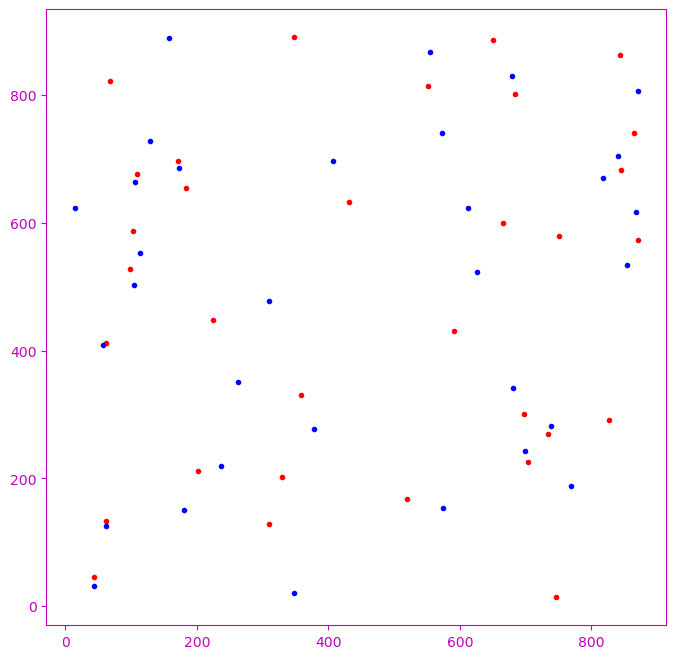

In [20]:
%matplotlib inline
import matplotlib

matplotlib.rc('axes', edgecolor='m')
plt.rcParams['xtick.color'] = 'm'
plt.rcParams['ytick.color'] = 'm'

frames = minushalf_df["frame"].unique()

fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.set_axis_off()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# plt.tight_layout()
white_frame = np.ones((2048,2048,3))

for f_num,f in enumerate(frames):
    
    minushalf = minushalf_df[minushalf_df["frame"]==f]
    plushalf = plushalf_df[plushalf_df["frame"]==f]
    
    alpha_half, scale_half = .9, 40   
    ax.clear() 
    # ax.imshow(white_frame, "gray")
    ax.plot(plushalf['x'], plushalf['y'],'r.',markersize=6, alpha=1)
    # ax.quiver(plushalf['x'], plushalf['y'], 
    #     np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
    #     headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

    ax.plot(minushalf['x'], minushalf['y'],'b.',markersize=6, alpha=1)
    # for i in range(3):
    #     ax.quiver(minushalf['x'], minushalf['y'], 
    #         np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
    #         headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)  

    save_path = os.path.join(
        r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects",
        'Nematic2',
        'frame_' + str(f) + ".png"
        )
    # break
    ax.set_xlim([0, 900])
    ax.set_ylim([0, 900])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))

    progressBar(f_num, len(frames))
    # break

- (1) Compute trajectories with TrackMate
- (2) Combine TrackMate and Defect CSVs

In [6]:
minushalf_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\MinusHalf1.csv")
plushalf_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\PlusHalf1.csv")

minushalf_TM = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\MinusTM_spots.csv", skiprows=[1,2,3])
plushalf_TM = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\PlusTM_spots.csv", skiprows=[1,2,3])

first_frame = minushalf_df["frame"].min() # Validate this number in image folders
last_frame = minushalf_df["frame"].max() # Validate this number in image folders

print("  ////////    PLUS   //////////")
print([(plushalf_TM[plushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(plushalf_df[plushalf_df["frame"]==i+first_frame]).shape for i in range(10)])

print("\n ////////    MINUS   //////////")
print([(minushalf_TM[minushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(minushalf_df[minushalf_df["frame"]==i+first_frame]).shape for i in range(10)])

  ////////    PLUS   //////////
[(32, 20), (31, 20), (30, 20), (35, 20), (35, 20), (35, 20), (32, 20), (33, 20), (36, 20), (33, 20)]
[(32, 10), (31, 10), (30, 10), (35, 10), (35, 10), (35, 10), (32, 10), (33, 10), (36, 10), (33, 10)]

 ////////    MINUS   //////////
[(32, 20), (31, 20), (29, 20), (35, 20), (33, 20), (34, 20), (32, 20), (33, 20), (35, 20), (33, 20)]
[(32, 10), (31, 10), (29, 10), (35, 10), (33, 10), (34, 10), (32, 10), (33, 10), (35, 10), (33, 10)]


slope: 1.45148632411967 | intercept: -67.47480321265317
slope: 1.45148632411967 | intercept: -67.47480321265317
slope: 1.4514879924249442 | intercept: -67.41815227348916
-------  X  ------------
slope: 1.4608550430788443 | intercept: -66.72998874713409
slope: 1.4608550430788443 | intercept: -66.72998874713409
slope: 1.460792801438512 | intercept: -66.73851350644169
-------  Y  ------------


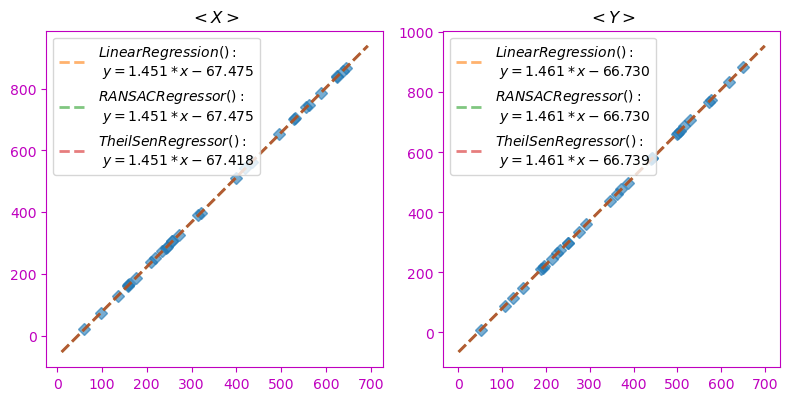

In [46]:
from sklearn import linear_model

%matplotlib inline
frame = 10

fig, axs = plt.subplots(1,2,  figsize=(8,16))

dims = ("x", "y")
lrs = (
    linear_model.LinearRegression(), 
    linear_model.RANSACRegressor(), 
    linear_model.TheilSenRegressor()
    )

slope_intercept = {}

for ax,dd in zip(axs, dims):
    ave_slope, ave_intercept = 0, 0

    X = plushalf_TM["POSITION_"+dd.upper()][plushalf_TM["FRAME"]==frame].iloc[:].sort_values().values
    y = plushalf_df[dd][plushalf_df["frame"]==first_frame+frame].iloc[:]

    if dd=="y":
        # !!! insert image height (e.g. 900)
        y = (900 - y) # y- values are flipped
    y = y.sort_values().values

    ax.plot(X, y, "D", alpha=.6)

    for lr in lrs:
        lr.fit(X.reshape(-1, 1), y)
        try:
            slope = lr.estimator_.coef_[0]
            intercept = lr.estimator_.intercept_
        except:
            slope = lr.coef_[0]
            intercept = lr.intercept_

        # use prints to set the SLOPE and INTERCEP globals in the next cell
        print('slope:', slope, '| intercept:', intercept)

        # prdict for line
        line_X = np.arange(X.min()-50, X.max()+50)[:, np.newaxis]
        line_y = lr.predict(line_X)

        ax.plot(line_X, line_y, "--", linewidth=2, alpha=.6,
                label="$%s:$\n $y= %.3f *x %.3f$" %(lr, slope, intercept))   
         
        ave_slope += slope  
        ave_intercept += intercept

    ax.set_title("$< %s >$" %dd.upper())

    ax.set_box_aspect(1)
    ax.legend(loc='upper left')
    print("-------  %s  ------------" %dd.upper())

    slope_intercept[dd] = {"slope": ave_slope/len(lrs),
                             "intercept": ave_intercept/len(lrs)
                             }

    # ave_slope = ave_slope/len(lrs)
    # ave_intercept = ave_intercept/len(lrs)
plt.tight_layout()

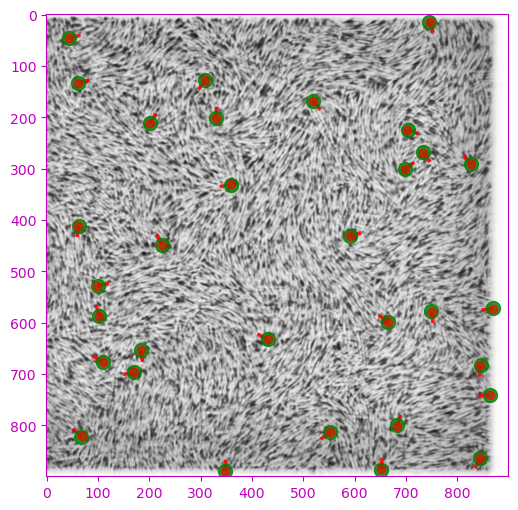

In [49]:
%matplotlib inline
SLOPEx = slope_intercept["x"]["slope"]
INTERCEPTx = slope_intercept["x"]["intercept"]
SLOPEy = slope_intercept["y"]["slope"]
INTERCEPTy = slope_intercept["y"]["intercept"]
frame = 0

image_list_all = glob.glob(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps/*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame-1:1]
im1 = image_list[0]

plushalf_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\PlusHalf1.csv")
plushalf_TM = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\PlusTM_spots.csv", skiprows=[1,2,3])

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,900:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(255-img_clahe, "gray")

x = plushalf_TM["POSITION_X"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEx + INTERCEPTx
y = h_img - (plushalf_TM["POSITION_Y"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEy + INTERCEPTy)
ax.plot(x, y,'go',markersize=10, alpha=.8)

alpha_half, scale_half = .9, 40  
p_df =  plushalf_df[plushalf_df["frame"]==first_frame+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6)
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

In [51]:
%matplotlib qt

def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    from scipy import spatial
    tree = spatial.KDTree(Xlong)
    _, minid = tree.query(Xshort)   
    return minid

minushalf_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\MinusHalf1.csv")
plushalf_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\PlusHalf1.csv")

minushalf_TM = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\MinusTM_spots.csv", skiprows=[1,2,3])
plushalf_TM = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\PlusTM_spots.csv", skiprows=[1,2,3])

first_frame = minushalf_df["frame"].min() # Validate this number in image folders

plushalf_TM["x_img"] = plushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
plushalf_TM["y_img"] = h_img - (plushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)
minushalf_TM["x_img"] = minushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
minushalf_TM["y_img"] = h_img - (minushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)

# find same dots and check
dfs_TM = [plushalf_TM, minushalf_TM]
dfs_ori = [plushalf_df, minushalf_df]

for df_TM, df_ori in zip(dfs_TM, dfs_ori):
    xy_ori = np.array([df_ori["x"], df_ori["y"]]).T
    xy_TM = np.array([df_TM["x_img"].values, df_TM["y_img"].values]).T
    idx = center_pairs(
        xy_ori, #Long Array
        xy_TM #Short Array
        ) 
    # break
    print(xy_ori[idx[100:103]],'\n', xy_TM[100:103],'\n', df_ori[['x', 'y']].loc[idx[100:103]].values)
    print("--------------")

    # replace and add angles
    df_TM[['x_img1','y_img1','ang1','ang2','ang3','charge']] =  df_ori[['x', 'y','ang1','ang2','ang3','charge']].iloc[idx[:]].values


[[578. 729.]
 [628. 891.]
 [846. 860.]] 
 [[578.45574213 728.61684011]
 [627.80629606 890.76944695]
 [845.52932809 860.09192674]] 
 [[578. 729.]
 [628. 891.]
 [846. 860.]]
--------------
[[ 23. 843.]
 [864. 803.]
 [637. 535.]] 
 [[ 22.53626701 842.56191519]
 [864.39865754 803.1193892 ]
 [636.51521734 534.32587876]] 
 [[ 23. 843.]
 [864. 803.]
 [637. 535.]]
--------------


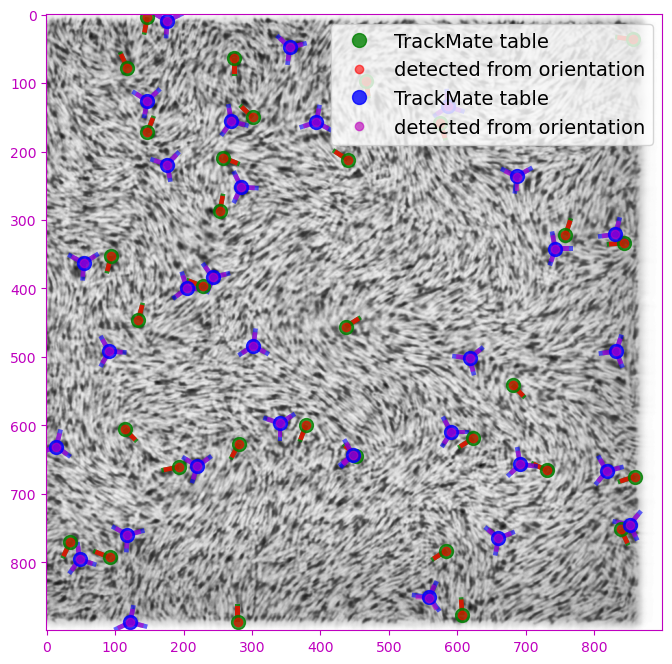

In [52]:
# test replaced values
%matplotlib inline
frame = 20

image_list_all = glob.glob(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps/*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame-1:1]
im1 = image_list[frame]

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,900:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(255-img_clahe, "gray")

# +1/2
idx = plushalf_TM["FRAME"]==frame
ax.plot(plushalf_TM["x_img1"][idx],
        plushalf_TM["y_img1"][idx],'go',
        markersize=10, alpha=.8, label="TrackMate table")
ax.quiver(plushalf_TM['x_img1'][idx], plushalf_TM['y_img1'][idx], 
    np.cos(plushalf_TM['ang1'][idx]), -np.sin(plushalf_TM['ang1'][idx]), 
    headaxislength=0, headwidth=0, headlength=0, color='g', scale=35, alpha=.8)        

p_df =  plushalf_df[plushalf_df["frame"]==first_frame+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6, label="detected from orientation")
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=40, alpha=.8)

# -1/2
idx = minushalf_TM["FRAME"]==frame
ax.plot(minushalf_TM["x_img1"][idx],
        minushalf_TM["y_img1"][idx],'bo',
        markersize=10, alpha=.8, label="TrackMate table")
for i in range(3):
    ax.quiver(minushalf_TM["x_img1"][idx], minushalf_TM["y_img1"][idx], 
        np.cos(minushalf_TM['ang'+str(i+1)][idx]), -np.sin(minushalf_TM['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='b', scale=35, alpha=.6)    

m_df =  minushalf_df[minushalf_df["frame"]==first_frame+frame]
ax.plot(m_df['x'], m_df['y'],'mo',markersize=6, alpha=.6, label="detected from orientation")
for i in range(3):
    ax.quiver(m_df["x"], m_df["y"], 
        np.cos(m_df['ang'+str(i+1)][idx]), -np.sin(m_df['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='m', scale=45, alpha=.6)    

ax.legend(loc='upper right', fontsize=14)

In [53]:
# Join TrackMate tabels for +1/2 and -1/2
pd.concat([plushalf_TM, minushalf_TM]).to_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects/PlusAndMinusTM.csv")

# Start Here Find Pairs

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy import spatial
from sklearn.neighbors import KDTree
from scipy.stats import circmean
import os
import sys
import pandas as pd
import seaborn as sns
import sys,time,random
def progressBar(count_value, total, suffix=''):
    bar_length = 100
    filled_up_Length = int(round(bar_length* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    sys.stdout.write('[%s] %s%s ...%s\r' %(bar, percentage, '%', suffix))
    sys.stdout.flush()

plus_minus_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects/PlusAndMinusTM.csv")
plus_minus_df.head()

Unnamed: 0     LABEL      ID  TRACK_ID    QUALITY  POSITION_X  POSITION_Y  \
0           0  ID278212  278212       0.0  81.421532       552.0       478.0   
1           1  ID278213  278213       1.0  81.421532       531.0       508.0   
2           2  ID278214  278214       2.0  81.421524       185.0       517.0   
3           3  ID278215  278215       3.0  81.421524       274.0       524.0   
4           4  ID278208  278208       NaN  68.126724        90.0       380.0   

   POSITION_Z  POSITION_T  FRAME  ...  CONTRAST_CH1   SNR_CH1       x_img  \
0         0.0         0.0      0  ...      0.973672  1.625018  733.764838   
1         0.0         0.0      0  ...      0.973672  1.625018  703.283614   
2         0.0         0.0      0  ...      0.973672  1.625018  201.069153   
3         0.0         0.0      0  ...      0.973672  1.625018  330.251486   
4         0.0         0.0      0  ...      0.923249  1.053494   63.177900   

        y_img  x_img1  y_img1      ang1  ang2  ang3  charge  
0  268.454037   734.0   269.0  0.942478   NaN   NaN     0.5  
1  224.629008   703.0   225.0  0.314159   NaN   NaN     0.5  
2  211.481499   201.0   212.0 -1.005310   NaN   NaN     0.5  
3  201.255659   330.0   202.0 -1.507964   NaN   NaN     0.5  
4  411.615798    62.0   411.0  1.696460   NaN   NaN     0.5  

[5 rows x 29 columns]

In [2]:
from scipy import spatial
def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    tree = spatial.KDTree(Xlong)
    return tree.query(Xshort)   

pairs = []

plus_minus_df["FRAME"].unique()[-1]
for frame in plus_minus_df["FRAME"].unique()[:]:
    # print(frame)
    p_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==.5)
    m_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==-.5)
    plus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1"]][p_idx]
    minus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1","ang2","ang3"]][m_idx]

    dist, idx = center_pairs(minus_xy[["x_img1","y_img1"]], plus_xy[["x_img1","y_img1"]])
    # set a distance that define that defects are a pair (50)
    dist_tresh = dist<30
    # Notice: some TRACK_IDs are nan, meaning that they are not a part from any trajectory
    pairs.append([
        minus_xy["TRACK_ID"].iloc[idx][dist_tresh].values,#.astype(np.int_), 
        plus_xy["TRACK_ID"][dist_tresh].values,#.astype(np.intc)
        dist[dist_tresh]
        ]) 

# pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T, columns=["minus", "plus"]).dropna().drop_duplicates()    
pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T, columns=["minus", "plus","dist"]).dropna().drop_duplicates()
_, indices = np.unique(pairs_df["minus"], return_index=True)
pairs_df = pairs_df.iloc[indices].copy()

In [3]:
%matplotlib qt
from scipy.stats import circmean

def equlalize_trajectories(plus_minus_df, p_idx, m_idx):
    ''' makes sure that positive (p_idx) and negative (m_idx) defect trajectory are equal
    according to "FRAME" number
    if missing frame for one of them it removed with dropna()
    '''
    df1 = plus_minus_df[["FRAME", "x_img1","y_img1", "ang1" ]][p_idx]
    df1.set_index('FRAME', inplace=True)
    df2 =  plus_minus_df[["FRAME", "x_img1","y_img1", "ang1","ang2","ang3" ]][m_idx]
    df2.set_index('FRAME', inplace=True)
    df_ = pd.concat([df1, df2], axis=1).dropna()
    return df_.set_axis(["xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" ], axis=1)

minimal_track = 5
PLOT = False

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_box_aspect(1)
plt.set_cmap('plasma')
count = 0
mp_distance = []
mp_distance_fusion = []
mp_distance_creation = []
pair_stat = []
fusion_TF = 1
for (num,m), n in zip(enumerate(pairs_df["minus"]), pairs_df["plus"]):
    m_idx = np.logical_and(plus_minus_df["TRACK_ID"]==m, plus_minus_df["charge"]==-.5)
    p_idx = np.logical_and(plus_minus_df["TRACK_ID"]==n, plus_minus_df["charge"]==.5)
    # minimal track length (20 frames)
    if m_idx.sum()>minimal_track and p_idx.sum()>minimal_track:

        count +=1
        dff_ = equlalize_trajectories(plus_minus_df, p_idx, m_idx)
        # "xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" 
        xm, ym = dff_["xm"].values, dff_["ym"].values
        xp, yp = dff_["xp"].values, dff_["yp"].values
        thm = np.array((
            dff_["angm1"].values, 
            dff_["angm2"].values,
            dff_["angm3"].values
        ))
        thp = dff_["angp1"].values
        # thp[thp<0] = thp[thp<0] + 2*np.pi 

        pair_distance = ((xm-xp)**2 + (ym-yp)**2)**.5
        mp_distance.append(pair_distance)
        
        # if distance decrease = fusion
        fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
        if fusion:
            fusion_TF = 1
            mp_distance_fusion.append(pair_distance)
        else:
            fusion_TF = -1
            mp_distance_creation.append(pair_distance)
        
        # angle btw defect centers
        mp_angle = np.arctan2(ym-yp, xm-xp) 
        mp_angle[mp_angle<0] = mp_angle[mp_angle<0] + 2*np.pi
        
        # displacment angle of =1/2 defect
        p_vel_angle = np.arctan2(np.diff(yp), np.diff(xp)) 
        p_vel_angle[p_vel_angle<0] = p_vel_angle[p_vel_angle<0] + 2*np.pi

        diff_thm = (thm - thp).T
        diff_thm[diff_thm<0] = diff_thm[diff_thm<0] + 2*np.pi
        
        thm_min = np.min(np.abs(diff_thm), axis=1) + thp
        thm_min[thm_min<0] = thm_min[thm_min<0] + 2*np.pi
        pair_stat.append([thp-circmean(mp_angle), #np.median(mp_angle)
                          thm-circmean(mp_angle), 
                          p_vel_angle-circmean(mp_angle), 
                          (thp[:1]-p_vel_angle)%(2*np.pi),
                          fusion_TF * pair_distance # negative distance is creation
                        ]) # TODO add label to differerntiate btw fusing and creating pairs

        if PLOT:
            for i in range(3):
                ax.quiver(xm, ym, np.cos(thm[i]), np.sin(thm[i]),color="b", alpha=.3, scale=40)

            ax.quiver(xp, yp, np.cos(thp), np.sin(thp),color="r", alpha=.2)
            ax.quiver(xm, ym, np.cos(thm_min), np.sin(thm_min),color="m", alpha=.3, scale=40)

            ax.quiver(xp[-1], yp[-1], np.cos(thp[-1]), np.sin(thp[-1]),color="r", alpha=.6, scale=15)
            ax.quiver(xm[-1], ym[-1], np.cos(thm_min[-1]), np.sin(thm_min[-1]),color="b", alpha=.6, scale=15)

            ax.scatter(xm, ym, c=np.arange(len(xm)), s=40, alpha=.8)
            ax.scatter(xp, yp, c=np.arange(len(xp)), s=40, alpha=.8)
            # ax.text(xp[-1]-10, yp[-1]+10, str((thp[-1]*180/np.pi)//1), fontsize=20)
            ax.text(xp[-1], yp[-1], "%s" %str(((thp[-1]-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
            ax.text(xm[-1], ym[-1], "%s" %str(((thm.min()-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
    
    progressBar(num, len(pairs_df))

C:\Users\victo\AppData\Local\Temp\ipykernel_32580\1733538537.py:51: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\victo\AppData\Local\Temp\ipykernel_32580\1733538537.py:51: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_32580\1733538537.py:51: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
%matplotlib inline
# pair_stat.append([thp-circmean(mp_angle), #np.median(mp_angle)
#                     thm-circmean(mp_angle), 
#                     p_vel_angle-circmean(mp_angle), 
#                     (thp[:1]-p_vel_angle)%(2*np.pi),
#                     pair_distance
#                 ])
df = pd.DataFrame(data={
    "p_ang": np.concatenate([p[0] for p in pair_stat]), 
    "m_ang1": np.concatenate([p[1][0] for p in pair_stat]),
    "m_ang2": np.concatenate([p[1][1] for p in pair_stat]), 
    "m_ang3": np.concatenate([p[1][2] for p in pair_stat]), 
    # "p_vel_angle": np.concatenate([p[2] for p in pair_stat]), 
    # "X": np.concatenate(pair_stat)[:,3], 
    "distance": np.concatenate([pair[4] for pair in pair_stat]), 
    }).dropna()


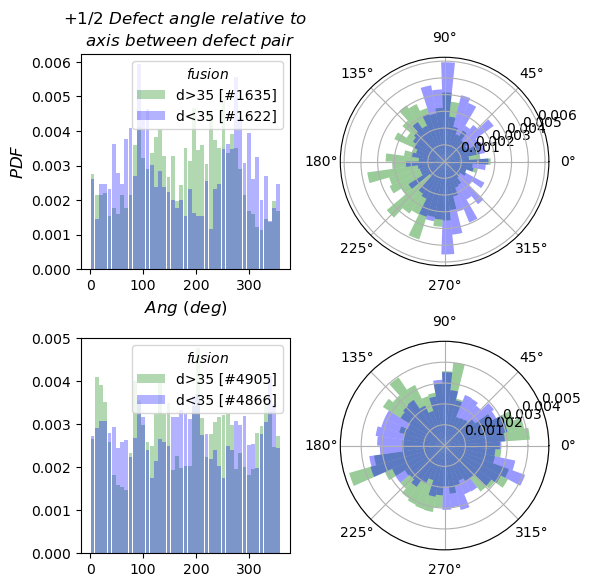

In [8]:
%matplotlib inline
dist = 35
bins_number = 45  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
width = 2 * np.pi / bins_number

fig3 = plt.figure(figsize=(6,6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222, projection='polar')
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, projection='polar')
ax1.set_ylabel("$PDF$", fontsize=12)
ax1.set_xlabel("$Ang~(deg)$", fontsize=12)

df_f = df[df["distance"]>0].copy()
df_cr = df[df["distance"]<0].copy()

# df1 = df_f[np.logical_and(
#                     df_f["distance"]>40, 
#                     df_f["distance"]<60,
#                    )].copy()

df1 = df_f.copy()
df1["distance"] = df1["distance"].abs()

m_ang_close, m_ang_far, m_ang_all = [], [], []
for i in range(3):
    m_ang_close.append(df1["m_ang"+str(i+1)][df1["distance"]<dist].values)
    m_ang_far.append(df1["m_ang"+str(i+1)][df1["distance"]>dist].values)
    m_ang_all.append(df1["m_ang"+str(i+1)].values)
m_ang_close = np.concatenate(m_ang_close)
m_ang_far = np.concatenate(m_ang_far)
m_ang_all = np.concatenate(m_ang_all)  

# p0,_,_ = ax3.hist((m_ang_all % (2*np.pi))*180/np.pi, bins*180/np.pi, 
#                     density=True, rwidth=.9, alpha=.3, color="red",
#                     label="all [#%s]" %(len(m_ang_all))
#                     )
# ax4.bar(bins[:bins_number], p0, width=width, bottom=0.0, alpha=.4, color="red")

p0,_,_ = ax3.hist((m_ang_far % (2*np.pi))*180/np.pi, bins*180/np.pi, 
                    density=True, rwidth=.9, alpha=.3, color="green",
                    label="d>%s [#%s]" %(dist, len(m_ang_far))
                    )
ax4.bar(bins[:bins_number], p0, width=width, bottom=0.0, alpha=.4, color="green")
p0,_,_ = ax3.hist((m_ang_close % (2*np.pi))*180/np.pi, bins*180/np.pi, 
                    density=True, rwidth=.9, alpha=.3, color="blue",
                    label="d<%s [#%s]" %(dist, len(m_ang_close))
                    )
ax4.bar(bins[:bins_number], p0, width=width, bottom=0.0, alpha=.4, color="blue")

# p0,_,_ = ax1.hist((df1["p_ang"] % (2*np.pi))*180/np.pi, bins*180/np.pi, 
#                   density=True, rwidth=.9, alpha=.3, color="red",
#                   label="all [#%s]" %(len(df1["p_ang"]))
#                   )
# ax2.bar(bins[:bins_number], p0, color="red", width=width, bottom=0.0, alpha=.5)

p1,_,_ = ax1.hist((df1["p_ang"][df1["distance"]>dist] % (2*np.pi))*180/np.pi, bins*180/np.pi, 
                  density=True, rwidth=.9, alpha=.3, color="green",
                  label="d>%s [#%s]" %(dist, len(df1["p_ang"][df1["distance"]>dist]))
                  )
ax2.bar(bins[:bins_number], p1, color="green", width=width, bottom=0.0, alpha=.4)

p2,_,_ = ax1.hist((df1["p_ang"][df1["distance"]<dist] % (2*np.pi))*180/np.pi, bins*180/np.pi,
                   density=True, rwidth=.9, alpha=.3, color="blue",
                   label="d<%s [#%s]" %(dist, len(df1["p_ang"][df1["distance"]<dist]))
                   )
ax2.bar(bins[:bins_number], p2, color="blue", width=width, bottom=0.0, alpha=.4)

ax1.legend(loc='upper right')
ax1.get_legend().set_title("$fusion$")
ax1.set_title("$+1/2 ~Defect ~angle ~relative ~to$\n $ ~axis ~between ~defect ~pair$")

ax3.legend(loc='upper right')
ax3.get_legend().set_title("$fusion$")
plt.tight_layout()

In [ ]:
np.median(df_f["distance"]), -np.median(df_cr["distance"])

(35.014282800023196, 42.01190307520001)

Median vals. 35.014282800023196 42.01190307520001


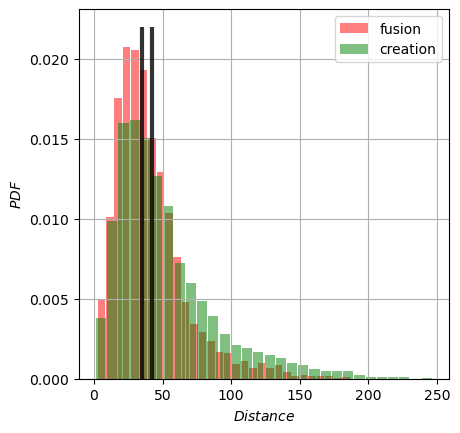

In [ ]:
%matplotlib inline
ax = df_f["distance"].hist(bins=30, density=True, rwidth=.9, label="fusion", color="red", alpha=.5)
ax.vlines(np.median(df_f["distance"]), 0, .022, "k", linewidth=3, alpha=.8)
(-1* df_cr["distance"]).hist(bins=30, density=True, rwidth=.9, label="creation", color="green",alpha=.5)
ax.vlines(-np.median(df_cr["distance"]), 0, .022, "k", linewidth=3, alpha=.8)
ax.set_box_aspect(1)
ax.set_ylabel("$PDF$"); ax.set_xlabel("$Distance$")
ax.legend(loc='upper right')
print("Median vals.", np.median(df_f["distance"]), -np.median(df_cr["distance"]))

Text(0.5, 1.0, '$Angle ~variation ~of ~+1/2 ~Defects$')

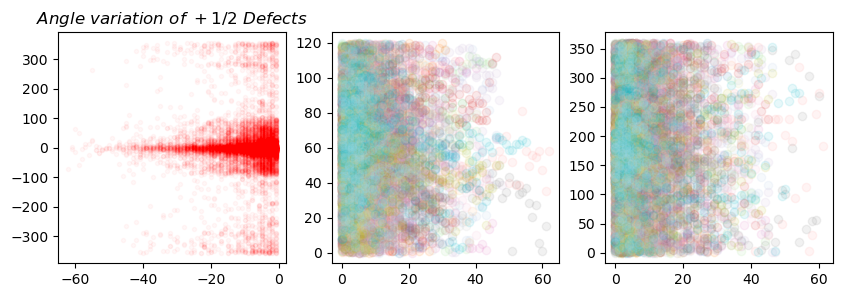

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1,3, figsize=(10,3))
colors = plt.cm.tab20(np.linspace(0, 1, num=len(pair_stat)))
plt.set_cmap('tab20')
pangles = []
pangles_early = []
pangles_late = []
mangles = []
mpangles = []
p_vel_angles = []
p_vel_angles_rel = []
for num, angs in enumerate(pair_stat):
    # print(angs[0],angs[1])
    # ax[0].plot(np.arange(len(angs[0])), np.fmod(angs[0], 2*np.pi)*180/np.pi, "o", alpha=.1)
    # ax[1].plot(np.arange(len(angs[1])), np.fmod(angs[1], 2*np.pi)*180/np.pi, "o", alpha=.05)
    pang = np.diff(angs[0])
    # pang[pang<0] = pang[pang<0] + 2*np.pi
    ax[0].plot(-len(pang)+np.arange(len(pang)), (pang+np.pi % (2*np.pi)) * 180/np.pi-180, ".", color="red", alpha=.03)
    ax[1].plot(np.arange(len(angs[1][0])), angs[1][0] % (2/3*np.pi) *180/np.pi, "o", color=colors[num], alpha=.1)

    pangles.append(angs[0][:-1])
    pangles_early.append(angs[0][:-10])
    pangles_late.append(angs[0][-10:])
    mangles.append(np.concatenate(angs[1]))
    p_vel_angles.append(angs[2])
    p_vel_angles_rel.append(angs[3])

    # mpangle = np.min((angs[1] - angs[0]) %(2*np.pi), axis=0)#[-3:]
    mpangles.append(np.concatenate(angs[1] - angs[0]))

    ax[2].plot(np.arange(len(angs[2])), np.array(angs[2]) %(2*np.pi) *180/np.pi, "o", color=colors[num], alpha=.1)
    
    # if num>25:
    #     break

# plt.figure(figsize=(3,3))
# plt.hist(np.concatenate(mpangles) % (2/3*np.pi) *180/np.pi , alpha=.2, rwidth=.9)
# ax[0].set_ylim([-10,370])
# ax[1].set_ylim([-10,130])
# ax[1].set_ylim([0,120])
# ax[0].set_xlim([-1,0])
ax[0].set_title("$Angle ~variation ~of ~+1/2 ~Defects$")

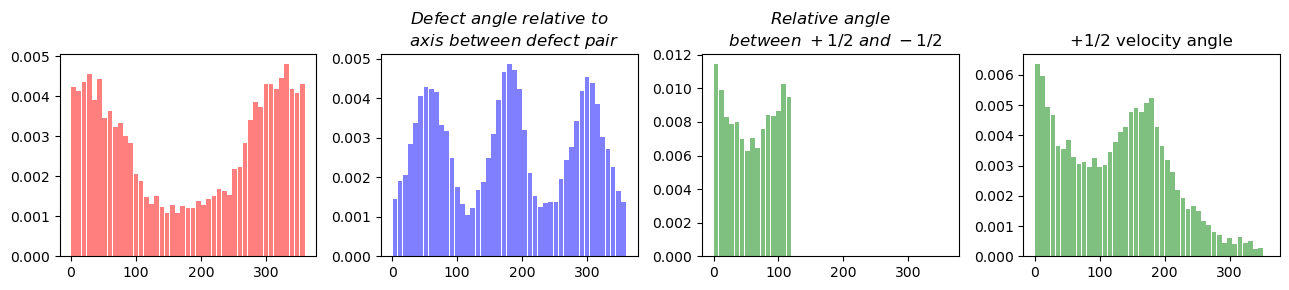

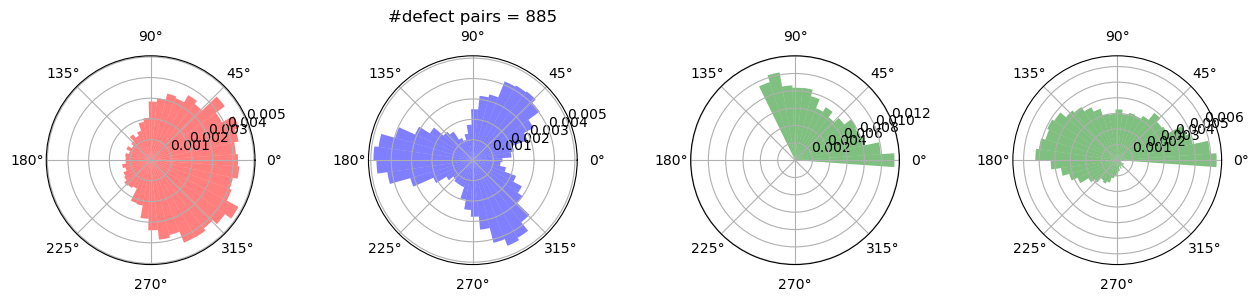

In [ ]:
%matplotlib inline
SAVE = True
bins_number = 45  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
pangle = np.concatenate(pangles) + 0 * 2*np.pi
mangle = np.concatenate(mangles) + 0 * 2/3*np.pi #2*np.pi * np.ones((1,100)).ravel() #
mpangle = np.concatenate(mpangles) + 0 * 2/3*np.pi
p_vel_angle = np.concatenate(p_vel_angles) + 0 * 2*np.pi

pangle = pangle % (2*np.pi)
mangle = mangle % (2*np.pi)
mpangle = mpangle % (2/3*np.pi)

fig1, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(13,3))

ax2.set_title("$Defect ~angle ~relative ~to$\n $ ~axis ~between ~defect ~pair $")
ax3.set_title("$Relative ~angle$ \n $~between ~+1/2 ~and ~-1/2$")
ax4.set_title(r"+1/2 velocity angle")
pn, _, _ =  ax1.hist(pangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="red")
mn, _, _ = ax2.hist(mangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="blue")
mpn, _, _ =  ax3.hist(mpangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="green")
p_vel, _, _ =  ax4.hist(p_vel_angle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="green")
plt.tight_layout()
os.makedirs(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\Images", exist_ok=True)
if SAVE:
    fig1.savefig(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\Images/ang_distribution_hist.png")


# plt.clf()
width = 2 * np.pi / bins_number
fig2, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, subplot_kw=dict(projection='polar'), figsize=(13,3))
ax1.bar(bins[:bins_number], pn, color="red",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], mn, color="blue",width=width, bottom=0.0, alpha=.5)
ax3.bar(bins[:bins_number], mpn, color="green",width=width, bottom=0.0, alpha=.5)
ax4.bar(bins[:bins_number], p_vel, color="green",width=width, bottom=0.0, alpha=.5)
ax2.set_title(r"#defect pairs = " + str(len(pair_stat)))
plt.tight_layout()
if SAVE:
    fig2.savefig(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\Images/ang_distribution_polhist.png")


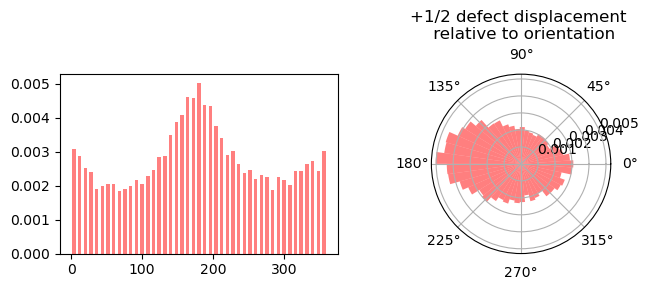

In [ ]:
fig3 = plt.figure(figsize=(7,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

p_vel_angle_rel =  np.concatenate(p_vel_angles) % (2*np.pi)

n, _, _ =  ax1.hist(p_vel_angle_rel*180/np.pi, bins*180/np.pi, density=True, rwidth=.6, alpha=.5, color="red")
ax2.bar(bins[:bins_number], n, color="red",width=width, bottom=0.0, alpha=.5)
plt.title("+1/2 defect displacement \n relative to orientation")
plt.tight_layout()
if SAVE:
    fig3.savefig(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\Images/p_direction_vs_displacement.png")

In [ ]:
# FUSION
mp_distance_fusion_mat = np.zeros([len(mp_distance_fusion), len(max(mp_distance_fusion, key = lambda x: len(x)))])
mp_distance_fusion_mat[:] = np.nan
for i, dist in enumerate(mp_distance_fusion):
    # plt.plot(np.arange(len(dist)), np.flip(dist), alpha=.2)  
    mp_distance_fusion_mat[i,0:len(dist)] = np.flip(dist)

# CREATION
mp_distance_creation_mat = np.zeros([len(mp_distance_creation), len(max(mp_distance_creation, key = lambda x: len(x)))])
mp_distance_creation_mat[:] = np.nan
for i, dist in enumerate(mp_distance_creation):  
    # plt.plot(np.arange(len(dist)), dist, alpha=.2) 
    # plt.scatter(np.arange(len(dist)), dist, c=np.arange(len(dist)), s=5, alpha=.2, cmap="plasma")     
    mp_distance_creation_mat[i,0:len(dist)] = dist  

mean_fusion, stdiv_fusion = np.flip(np.nanmean(mp_distance_fusion_mat, axis=0)), np.flip(np.nanstd(mp_distance_fusion_mat, axis=0))
mean_creation, stdiv_creation = np.nanmean(mp_distance_creation_mat, axis=0), np.nanstd(mp_distance_creation_mat, axis=0)     

## Fit fusion-creation mean trajectories

FUSION
slope: -2.101362990808495 | intercept: -16.03012126929124
Y=0 @ X=: -7.6284398932540824
CREATION
slope: 3.0705070755522166 | intercept: 25.941497131319846
Y=0 @ X=: -8.448603599669083


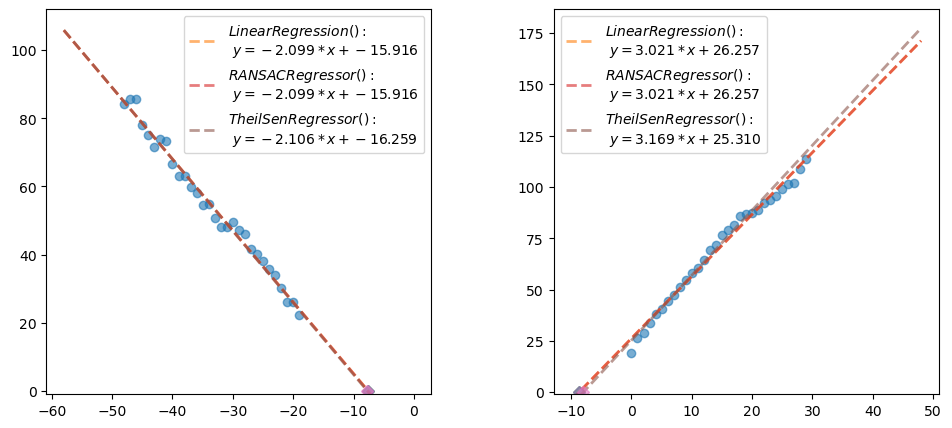

In [ ]:
%matplotlib inline
from sklearn import linear_model

means = {"fusion": mean_fusion[-30:], "creation": mean_creation[:30]}
fig, axs = plt.subplots(1,2,  figsize=(12,5))
axs = axs.ravel()

lrs = (
    linear_model.LinearRegression(), 
    linear_model.RANSACRegressor(), 
    linear_model.TheilSenRegressor()
    )

slope_intercept = {}

for ax, (name, mean) in zip(axs, means.items()):
    
    ave_slope, ave_intercept = 0, 0
    y = mean
    X = np.arange(len(mean))

    if name=="fusion":
        X = X - mp_distance_fusion_mat.shape[1]

    ax.plot(X, y, "o", alpha=.6)

    for lr in lrs:
        lr.fit(X.reshape(-1, 1), y)
        try:
            slope = lr.estimator_.coef_[0]
            intercept = lr.estimator_.intercept_
        except:
            slope = lr.coef_[0]
            intercept = lr.intercept_

        # prdict for line
        line_X = np.arange(X.min()-10, X.max()+20)[:, np.newaxis]
        line_y = lr.predict(line_X)

        ax.plot(line_X, line_y, "--", linewidth=2, alpha=.6,
                label="$%s:$\n $y= %.3f *x + %.3f$" %(lr, slope, intercept))   
        ax.plot(-intercept/slope, 0, "D", alpha=.6,)        
        ave_slope += slope  
        ave_intercept += intercept

    # use prints to set the SLOPE and INTERCEP globals in the next cell
    print(name.upper())
    print('slope:', ave_slope/len(lrs), '| intercept:', ave_intercept/len(lrs))
    print('Y=0 @ X=:', -ave_intercept/ave_slope)
    slope_intercept[name] = {"slope": ave_slope/len(lrs), "intercept": ave_intercept/len(lrs)}


    ax.set_box_aspect(1)
    ax.set_ylim([-1,None])

    ax.legend(loc='upper left')
    if name=="fusion":
        ax.legend(loc='upper right')

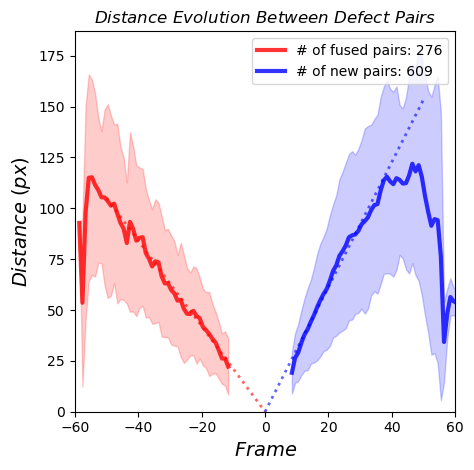

In [ ]:
%matplotlib inline
# FUSION
slope_fusion, intercept_fusion = slope_intercept["fusion"]["slope"], slope_intercept["fusion"]["intercept"] #-2.0 , 23.72
fusion_tshift = - intercept_fusion/slope_fusion -3
# mean_fusion, stdiv = np.flip(np.nanmean(mp_distance_fusion_mat, axis=0)), np.flip(np.nanstd(mp_distance_fusion_mat, axis=0))
time_fusion = np.arange(len(mean_fusion)) - mp_distance_fusion_mat.shape[1] + fusion_tshift

# uncomment to plot in same direction 
# mean, stdiv = np.nanmean(mp_distance_fusion_mat, axis=0), np.nanstd(mp_distance_fusion_mat, axis=0)
# max_frame = 0

plt.plot(time_fusion, mean_fusion, "r-", alpha=.8, linewidth=3,
    label="# of fused pairs: %s" % (mp_distance_fusion_mat.shape[0]))
plt.fill_between(time_fusion, mean_fusion-stdiv_fusion, mean_fusion+stdiv_fusion, color="red", alpha=.2)
xfit = np.array([-50,0])
plt.plot(xfit, slope_fusion * xfit, linestyle="dotted", color="red", alpha=.6, linewidth=2)

# CREATION
slope_creation, intercept_creation =  slope_intercept["creation"]["slope"], slope_intercept["creation"]["intercept"]#2.98, 27.25
creation_tshift = - intercept_creation/slope_creation
# mean_creation, stdiv = np.nanmean(mp_distance_creation_mat, axis=0), np.nanstd(mp_distance_creation_mat, axis=0)
time_creation = np.arange(len(mean_creation)) - creation_tshift

plt.plot(time_creation, mean_creation, "b-", alpha=.8, linewidth=3,
    label="# of new pairs: %s" % (mp_distance_creation_mat.shape[0]))
plt.fill_between(time_creation, mean_creation-stdiv_creation, mean_creation+stdiv_creation, color="b", alpha=.2)
xfit = np.array([0,50])
plt.plot(xfit, slope_creation * xfit, linestyle="dotted", color="b", alpha=.6, linewidth=2,
    )

plt.ylim([0,None])
lim = 60
plt.xlim([-lim,lim])
plt.gca().set_box_aspect(1)  
plt.xlabel(r'$Frame$', fontsize=14)
plt.ylabel(r'$Distance ~(px)$', fontsize=14) #plt.ylabel('$Distance ~(\mu m)$')
plt.title(r'$Distance ~Evolution ~Between ~Defect ~Pairs$')
plt.tight_layout()
plt.legend()

if SAVE:
    plt.savefig(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\Images/defect_pair_distance.png")
 

In [ ]:
def cofidence_range(X,y):
    import statsmodels.api as sm
    alpha = 0.05 # 95% confidence interval
    lr = sm.OLS(y, sm.add_constant(X)).fit()
    conf_interval = lr.conf_int(alpha)
    print("slope 95% CI ", "[%.2f, %.2f]" % (conf_interval[1][0], conf_interval[1][1]))    


for name, mean in means.items():
    y = mean
    X = np.arange(len(mean))
    print(name.upper())
    cofidence_range(X,y)

# Output of conf_interval
#  lower upper
# [-1.234 0.765]
# [-0.345 0.154]
# This means that we are 95% confident that the true value of the first parameter is between -1.234 and 0.765, 
# and we are 95% confident that the true value of the second parameter is between -0.345 and 0.154.

FUSION
slope 95% CI  [-2.20, -2.00]
CREATION
slope 95% CI  [2.89, 3.16]
